In [1]:
import os

import pandas as pd
import numpy as np

from dotenv import load_dotenv
from nixtlats import TimeGPT
from IPython.display import Markdown

currDir = os.getcwd()
os.chdir("../data")
from dataUtils import generateQuery, dataPrep
os.chdir("../usage")
from usageUtils import getUsage
os.chdir(currDir)

load_dotenv()

True

In [2]:
# Create a Kusto query to get sample data set from Azure Data Explorer

tenant = "MS-DSM06PrdStp04A"
start = "2023-09-08"
end = "2024-03-03"

generateQuery(tenantId=tenant, startDate=start, endDate=end)

XStoreAccountBillingDaily
    | where Tenant == "MS-DSM06PrdStp04A"
        and TimePeriod >= datetime(2023-09-08)
        and TimePeriod <= datetime(2024-03-03)
        and Environment != "Test"
        and isnotempty(MeterId)
    | where StgMeterName != "StgBlockBlobArchivePriorityRetrievalOperationUnitsBilled"
    | summarize ProratedQuantity = sum(ProratedQuantity) by bin(TimePeriod,1d), Tenant
    | project TimePeriod, Tenant, ProratedQuantity


NOTE: For now, I'm manually pasting the query (copied to clipboard using pyperclip) into ADE and running it, exporting the result to csv, and finally saving that csv into this project directory. Fine for testing, but could possibly improve that process!

In [3]:
timegpt = TimeGPT(token=os.getenv("TIMEGPT_TOKEN"))

timegpt.validate_token()

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

In [4]:
# Get current API token usage data

getUsage()

Current usage data:

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  64   ||   TOKENS:  230769   ||   SPENT:  362.51          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [5]:
# Input params for sample billing data and run data prep function

bd = dataPrep(
    df="df",
    filename="billing1",
    timeCol="TimePeriod",
    dropCols=["Tenant"],
)

display(bd.head())

,TimePeriod,ProratedQuantity
0,2023-09-08,1.167562e+06
1,2023-09-09,1.220100e+06
2,2023-09-10,1.184406e+06
3,2023-09-11,1.322509e+06
4,2023-09-12,1.330776e+06


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (Default 99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
0,2023-10-09,0,1.418832e+06,1688277.875,1.957724e+06
1,2023-10-10,0,1.488189e+06,1757634.875,2.027081e+06
2,2023-10-11,0,1.495546e+06,1764991.250,2.034437e+06
3,2023-10-12,0,1.496953e+06,1766398.500,2.035844e+06
4,2023-10-13,0,1.468383e+06,1737828.750,2.007274e+06
...,...,...,...,...,...
142,2024-02-28,0,2.233362e+06,2502807.500,2.772253e+06
143,2024-02-29,0,2.233207e+06,2502652.250,2.772098e+06
144,2024-03-01,0,2.160278e+06,2429723.750,2.699169e+06
145,2024-03-02,0,1.944523e+06,2213968.250,2.483414e+06


### Detected Anomalies (Default 99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
87,2024-01-04,1,1.217690e+06,1487136.000,1.756582e+06
88,2024-01-05,1,1.197563e+06,1467008.625,1.736454e+06
103,2024-01-20,1,1.356944e+06,1626389.750,1.895835e+06
104,2024-01-21,1,1.250522e+06,1519967.250,1.789413e+06
129,2024-02-15,1,1.851312e+06,2120758.000,2.390204e+06


### Results Comparison Plot (Default 99% Prediction Interval Level)

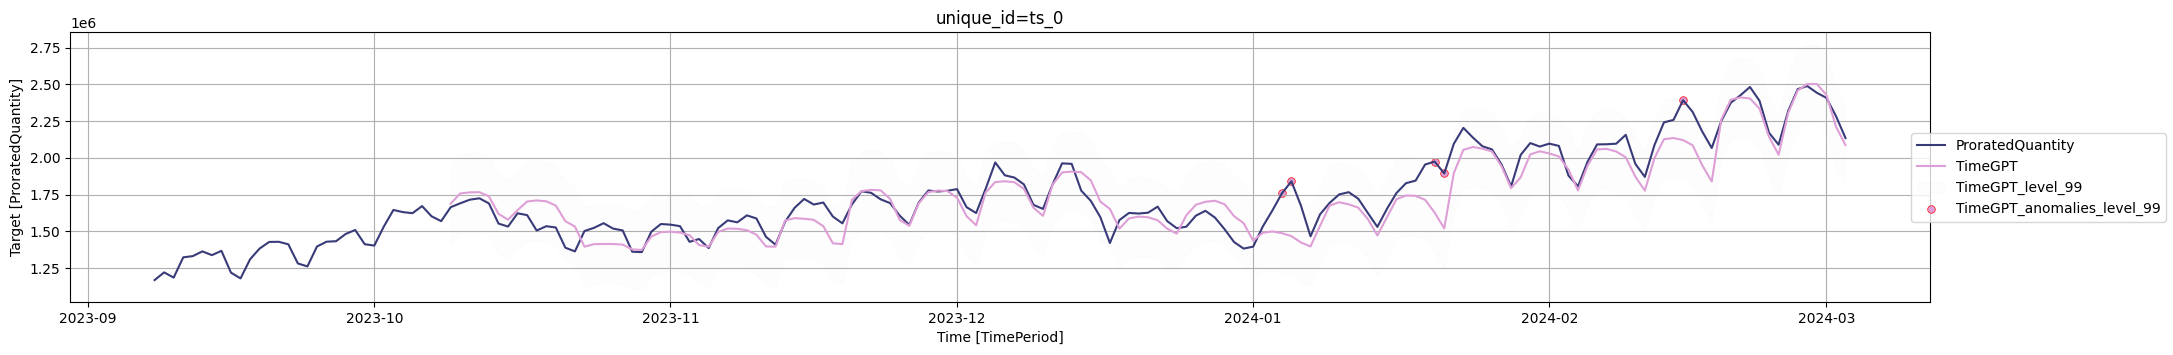

In [6]:
# Run anomaly detection model, plot results compared with original data (default prediction interval level is 99)

bdDtct = timegpt.detect_anomalies(
    bd, time_col="TimePeriod", target_col="ProratedQuantity", freq="D"
)

bdAnms = bdDtct[bdDtct["anomaly"] == 1]

bdPlt = timegpt.plot(
    bd, bdDtct, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (Default 99% Prediction Interval Level)"),
    bdDtct,
    Markdown("### Detected Anomalies (Default 99% Prediction Interval Level)"),
    bdAnms,
    Markdown("### Results Comparison Plot (Default 99% Prediction Interval Level)"),
    bdPlt,
)

In [7]:
# Get updated API token usage data

getUsage(update=True)

Usage data successfully updated with:               

<<  1 call  •  913 tokens  •  2.57 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  65   ||   TOKENS:  231682   ||   SPENT:  365.08          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [8]:
# Get historical prediction intervals to test against detected anomalies

bdFcst = timegpt.forecast(
    bd, h=1, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", add_history=True, level=[99, 90, 99.99],
)

bdFcst = bdFcst.merge(bd)

for lv in [99, 90, 99.99]:
    bdFcst[f"anomaly_{lv}"] = (
        bdFcst["ProratedQuantity"] > bdFcst[f"TimeGPT-hi-{lv}"]
    ) | (
        bdFcst["ProratedQuantity"] < bdFcst[f"TimeGPT-lo-{lv}"]
    )

    bdFcst[f"anomaly_{lv}"] = bdFcst[f"anomaly_{lv}"].astype(np.int64)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Calling Historical Forecast Endpoint...


In [9]:
# Get updated API token usage data

getUsage(update=True)

Usage data successfully updated with:               

<<  2 calls  •  1539 tokens  •  4.22 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  67   ||   TOKENS:  233221   ||   SPENT:  369.30          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [10]:
# Test detected anomalies against historical prediction intervals defalut level 99

pd.testing.assert_series_equal(
    bdFcst["anomaly_99"],
    bdDtct.merge(bd)["anomaly"],
    check_index=False,
    check_names=False,
)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (90% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-90,TimeGPT,TimeGPT-hi-90
0,2023-10-09,0,1.516217e+06,1688277.875,1.860338e+06
1,2023-10-10,0,1.585574e+06,1757634.875,1.929695e+06
2,2023-10-11,0,1.592931e+06,1764991.250,1.937052e+06
3,2023-10-12,0,1.594338e+06,1766398.500,1.938459e+06
4,2023-10-13,0,1.565768e+06,1737828.750,1.909889e+06
...,...,...,...,...,...
142,2024-02-28,0,2.330747e+06,2502807.500,2.674868e+06
143,2024-02-29,0,2.330592e+06,2502652.250,2.674713e+06
144,2024-03-01,0,2.257663e+06,2429723.750,2.601784e+06
145,2024-03-02,0,2.041908e+06,2213968.250,2.386029e+06


### Detected Anomalies (90% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-90,TimeGPT,TimeGPT-hi-90
9,2023-10-18,1,1.538111e+06,1710171.625,1.882232e+06
12,2023-10-21,1,1.396780e+06,1568840.500,1.740901e+06
40,2023-11-18,1,1.246201e+06,1418261.125,1.590322e+06
69,2023-12-17,1,1.480144e+06,1652204.875,1.824265e+06
82,2023-12-30,1,1.430921e+06,1602981.750,1.775042e+06
83,2023-12-31,1,1.382644e+06,1554704.625,1.726765e+06
87,2024-01-04,1,1.315075e+06,1487136.000,1.659197e+06
88,2024-01-05,1,1.294948e+06,1467008.625,1.639069e+06
89,2024-01-06,1,1.251483e+06,1423543.625,1.595604e+06
102,2024-01-19,1,1.541762e+06,1713822.750,1.885883e+06


### Results Comparison Plot (90% Prediction Interval Level)

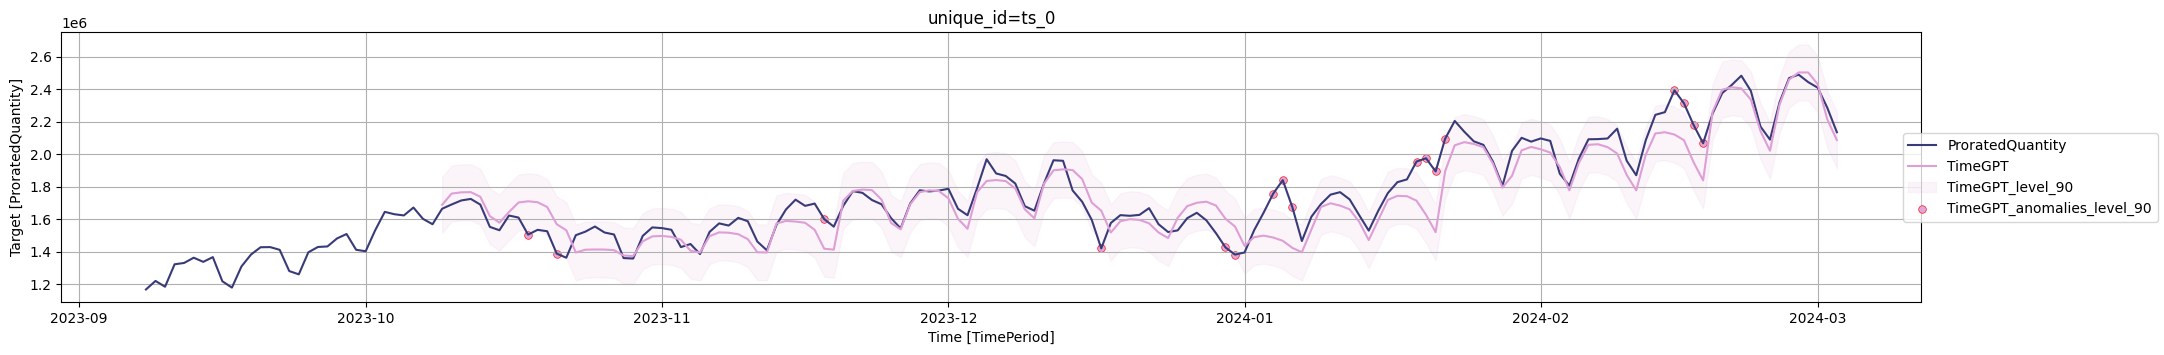

In [11]:
# Run anomaly detection model, plot results compared with original data (prediction interval level 90 should identify more anomalies)

bdDtct90 = timegpt.detect_anomalies(
    bd, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", level=90
)

bdAnms90 = bdDtct90[bdDtct90["anomaly"] == 1]

bdPlt90 = timegpt.plot(
    bd, bdDtct90, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (90% Prediction Interval Level)"),
    bdDtct90,
    Markdown("### Detected Anomalies (90% Prediction Interval Level)"),
    bdAnms90,
    Markdown("### Results Comparison Plot (90% Prediction Interval Level)"),
    bdPlt90,
)

In [13]:
# Get updated API token usage data

getUsage(update=True)

Usage data successfully updated with:               

<<  1 call  •  913 tokens  •  2.57 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  68   ||   TOKENS:  234134   ||   SPENT:  371.87          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [14]:
# Test detected anomalies against historical prediction interval level 90

pd.testing.assert_series_equal(
    bdFcst["anomaly_90"],
    bdDtct90.merge(bd)["anomaly"],
    check_index=False,
    check_names=False,
)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (99.99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99
0,2023-10-09,0,1.281301e+06,1688277.875,2.095255e+06
1,2023-10-10,0,1.350658e+06,1757634.875,2.164612e+06
2,2023-10-11,0,1.358014e+06,1764991.250,2.171968e+06
3,2023-10-12,0,1.359422e+06,1766398.500,2.173375e+06
4,2023-10-13,0,1.330852e+06,1737828.750,2.144806e+06
...,...,...,...,...,...
142,2024-02-28,0,2.095831e+06,2502807.500,2.909784e+06
143,2024-02-29,0,2.095675e+06,2502652.250,2.909629e+06
144,2024-03-01,0,2.022747e+06,2429723.750,2.836701e+06
145,2024-03-02,0,1.806991e+06,2213968.250,2.620945e+06


### Detected Anomalies (99.99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99


### Results Comparison Plot (99.99% Prediction Interval Level)

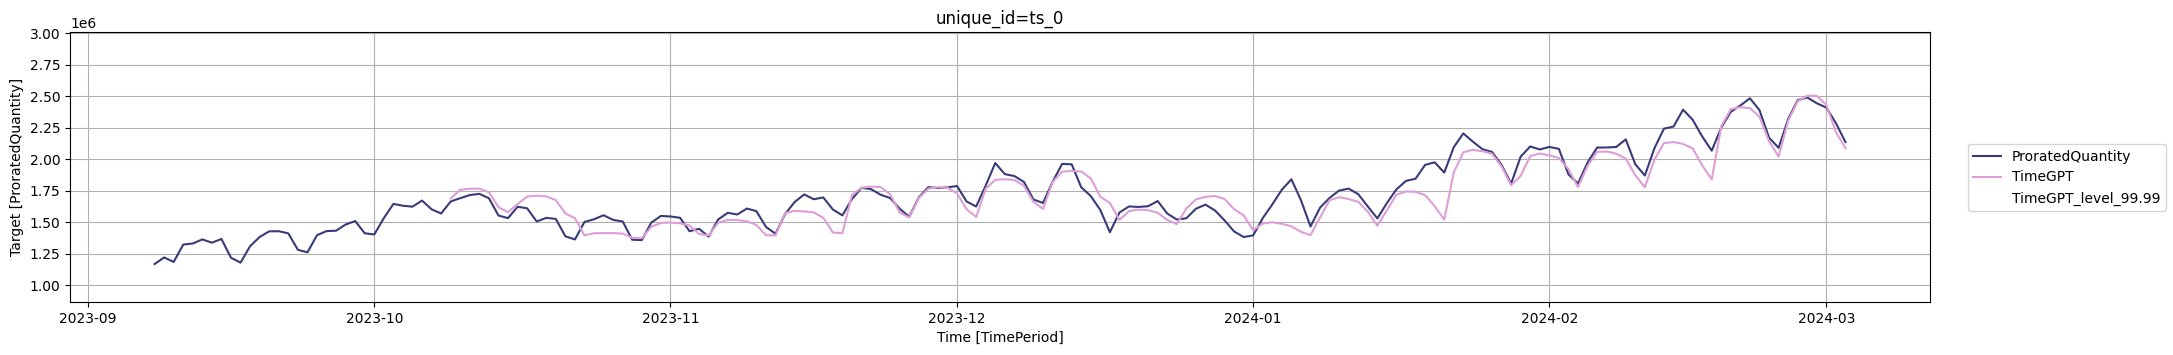

In [15]:
# Run anomaly detection model, plot results compared with original data (prediction interval level 99.99 should identify fewer anomalies)

bdDtct99_99 = timegpt.detect_anomalies(
    bd, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", level=99.99,
)

bdAnms99_99 = bdDtct99_99[bdDtct99_99["anomaly"] == 1]

bdPlt99_99 = timegpt.plot(
    bd, bdDtct99_99, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (99.99% Prediction Interval Level)"),
    bdDtct99_99,
    Markdown("### Detected Anomalies (99.99% Prediction Interval Level)"),
    bdAnms99_99,
    Markdown("### Results Comparison Plot (99.99% Prediction Interval Level)"),
    bdPlt99_99,
)

In [16]:
# Get updated API token usage data

getUsage(update=True)

Usage data successfully updated with:               

<<  1 call  •  913 tokens  •  2.57 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  69   ||   TOKENS:  235047   ||   SPENT:  374.44          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [17]:
# Test detected anomalies against historical prediction interval level 99.99

pd.testing.assert_series_equal(
    bdFcst["anomaly_99.99"],
    bdDtct99_99.merge(bd)["anomaly"],
    check_index=False,
    check_names=False,
)

In [18]:
# Get historical prediction intervals to test against detected anomalies with exogenous variables

bdFcstX = timegpt.forecast(
    bd, h=1, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", add_history=True, date_features=True, level=[99, 90, 99.99],
)

bdFcstX = bdFcstX.merge(bd)

for lv in [99, 90, 99.99]:
    bdFcstX[f"anomaly_{lv}"] = (
        bdFcstX["ProratedQuantity"] > bdFcstX[f"TimeGPT-hi-{lv}"]
    ) | (
        bdFcstX["ProratedQuantity"] < bdFcstX[f"TimeGPT-lo-{lv}"]
    )

    bdFcstX[f"anomaly_{lv}"] = bdFcstX[f"anomaly_{lv}"].astype(np.int64)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Using the following exogenous variables: year_2023, year_2024, month_1, month_2, month_3, month_9, month_10, month_11, month_12, day_1, day_2, day_3, day_4, day_5, day_6, day_7, day_8, day_9, day_10, day_11, day_12, day_13, day_14, day_15, day_16, day_17, day_18, day_19, day_20, day_21, day_22, day_23, day_24, day_25, day_26, day_27, day_28, day_29, day_30, day_31, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Calling Historical Forecast Endpoint...


In [19]:
# Get updated API token usage data

getUsage(update=True)

Usage data successfully updated with:               

<<  2 calls  •  18365 tokens  •  24.40 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  71   ||   TOKENS:  253412   ||   SPENT:  398.84          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...
INFO:nixtlats.timegpt:Using the following exogenous variables: year_2023, year_2024, month_1, month_2, month_3, month_9, month_10, month_11, month_12, day_1, day_2, day_3, day_4, day_5, day_6, day_7, day_8, day_9, day_10, day_11, day_12, day_13, day_14, day_15, day_16, day_17, day_18, day_19, day_20, day_21, day_22, day_23, day_24, day_25, day_26, day_27, day_28, day_29, day_30, day_31, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6


### Anomalies Detection Result (99.99% Prediction Interval Level with Exogeneous Variables)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99
0,2023-10-09,0,1.305223e+06,1.701976e+06,2.098729e+06
1,2023-10-10,0,1.371348e+06,1.768101e+06,2.164854e+06
2,2023-10-11,0,1.379074e+06,1.775827e+06,2.172580e+06
3,2023-10-12,0,1.370964e+06,1.767717e+06,2.164470e+06
4,2023-10-13,0,1.340459e+06,1.737212e+06,2.133965e+06
...,...,...,...,...,...
142,2024-02-28,0,2.111405e+06,2.508158e+06,2.904911e+06
143,2024-02-29,0,2.105716e+06,2.502469e+06,2.899222e+06
144,2024-03-01,0,2.029535e+06,2.426288e+06,2.823041e+06
145,2024-03-02,0,1.820125e+06,2.216878e+06,2.613631e+06


### Detected Anomalies (99.99% Prediction Interval Level with Exogeneous Variables)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99


### Results Comparison Plot (99.99% Prediction Interval Level with Exogeneous Variables)

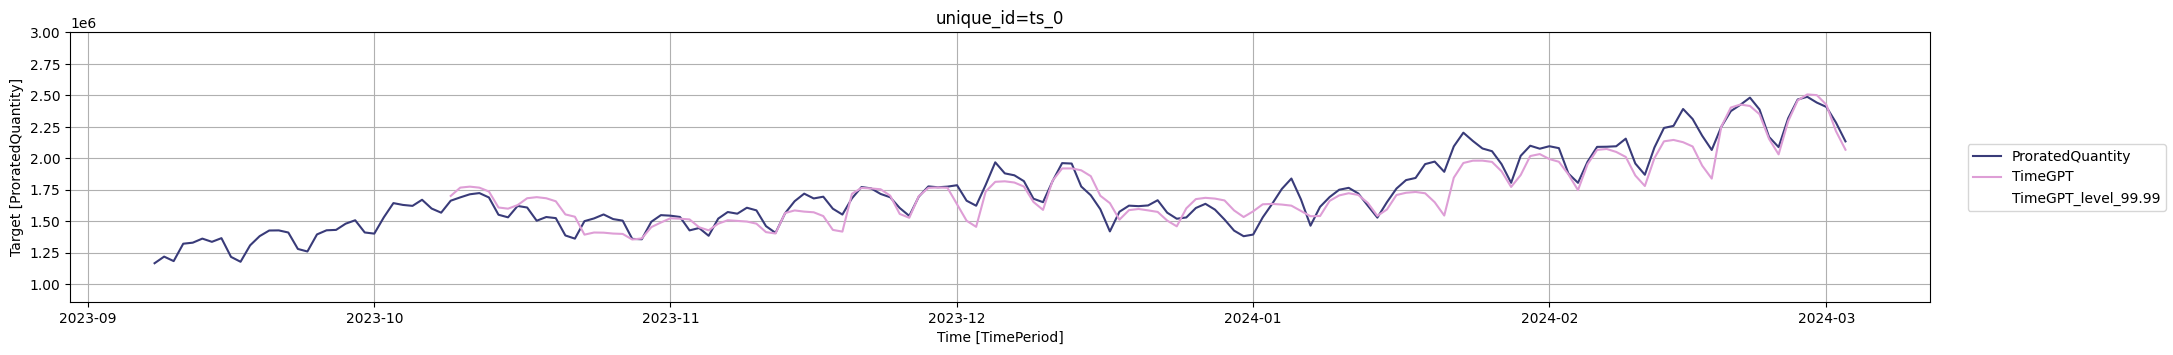

In [20]:
# Run anomaly detection model with exogeneous variables, plot results compared with original data (prediction interval level 99.99 should identify fewer anomalies)

bdDtctX99_99 = timegpt.detect_anomalies(
    bd, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", date_features=True, level=99.99,
)

bdAnmsX99_99 = bdDtctX99_99[bdDtctX99_99["anomaly"] == 1]

bdPltX99_99 = timegpt.plot(
    bd, bdDtctX99_99, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (99.99% Prediction Interval Level with Exogeneous Variables)"),
    bdDtctX99_99,
    Markdown("### Detected Anomalies (99.99% Prediction Interval Level with Exogeneous Variables)"),
    bdAnmsX99_99,
    Markdown("### Results Comparison Plot (99.99% Prediction Interval Level with Exogeneous Variables)"),
    bdPltX99_99,
)

In [21]:
# Get updated API token usage data

getUsage(update=True)

Usage data successfully updated with:               

<<  1 call  •  9279 tokens  •  12.60 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  72   ||   TOKENS:  262691   ||   SPENT:  411.44          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [22]:
# Test detected anomalies with exogeneous variables against historical prediction interval level 99.99

pd.testing.assert_series_equal(
    bdFcstX["TimeGPT-lo-99.99"],
    bdDtctX99_99.merge(bd)["TimeGPT-lo-99.99"],
    check_index=False,
    check_names=False,
    rtol=1,
    atol=1,
)